In [1]:
import os, sys, pickle, re, math
from tqdm import tqdm_notebook as tqdm
import numpy as np
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path = list(set(sys.path))
import matplotlib.pyplot as plt

from results_path import DDPG_PATH, PPO_PATH

from common.evaluate import make_vis_env, test_env

from flow.multiagent_envs import MultiWaveAttenuationMergePOEnv
from flow.scenarios import MergeScenario
from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder
from ray.tune import run_experiments

import gym, ray
from ray.rllib.agents.ppo import PPOAgent, DEFAULT_CONFIG
from ray.rllib.agents.ddpg import DDPGAgent, DEFAULT_CONFIG
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print

exp_name = 'buff_obs'
checkpoint = '50'

results_list = os.listdir('/headless/ray_results/' + exp_name)

benchmark_name = 'multi_merge'
benchmark = __import__(
    "flow.benchmarks.%s" % benchmark_name, fromlist=["flow_params"])
flow_params = benchmark.buffered_obs_flow_params
horizon = flow_params['env'].horizon
create_env, env_name = make_create_env(params=flow_params, version=0)

ray.init(num_cpus=1, include_webui=False, ignore_reinit_error=True)

Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-04-28_17-20-47_46206/logs.
Waiting for redis server at 127.0.0.1:40554 to respond...
Waiting for redis server at 127.0.0.1:11866 to respond...
Starting the Plasma object store with 20.0 GB memory using /dev/shm.


{'node_ip_address': '10.138.0.2',
 'object_store_addresses': ['/tmp/ray/session_2019-04-28_17-20-47_46206/sockets/plasma_store'],
 'raylet_socket_names': ['/tmp/ray/session_2019-04-28_17-20-47_46206/sockets/raylet'],
 'redis_address': '10.138.0.2:40554',
 'webui_url': ''}

In [2]:
results = {}
register_env(env_name, create_env)

for AGENT_PATH in tqdm(results_list, desc='Results'):
    print('AGENT_PATH: {}'.format(AGENT_PATH))
    
    EXP = AGENT_PATH
    index = [(i.start(), i.end())for i in re.finditer('_', EXP)]
    EXP = EXP[index[1][1]:index[-3][0]]
    
    AGENT = AGENT_PATH[:AGENT_PATH.find('_')]
    PATH = exp_name + '/' + AGENT_PATH
    
    config_path = '/headless/rl_project/ray_results/' + PATH + '/params.pkl'
    checkpoint_path = '/headless/rl_project/ray_results/' + PATH + '/checkpoint_{}/checkpoint-{}'.format(checkpoint, checkpoint)

    with open(config_path, mode='rb') as f:
        config = pickle.load(f)

    if AGENT == 'PPO':
        agent = PPOAgent(config=config, env=env_name)
    elif AGENT == 'DDPG':
        agent = DDPGAgent(config=config, env=env_name)
        
    try:
        agent.restore(checkpoint_path)
    except:
        print("{} \n checkpoint doesn't exist".format(PATH + '/checkpoint_{}/checkpoint-{}'.format(checkpoint, checkpoint)))
        pass
    
    env = create_env()
    # calculate the space-time velocity map
    left_length = env.k.scenario.edge_length('left')
    car_length = 5.0
    scale = 10

    state = env.reset()
    vel = []
    outflow = []
    vel_map_list = []
    for i in tqdm(range(env.env_params.horizon), desc='env step'):
        # record the mean velocity
        v = np.mean(env.k.vehicle.get_speed(env.k.vehicle.get_ids()))
        vel.append(v)

        # record the velocity map
        ids = env.k.vehicle.get_ids()
        vel_map_ = np.zeros(int(left_length)*scale)
        for id_ in ids:
            pos_ = np.round(env.k.vehicle.get_position(id_), decimals=1)
            vel_ = env.k.vehicle.get_speed(id_)
            pos_bottom = max(0, int((pos_-car_length/2.0)*scale))
            pos_top = min(int(left_length)*scale, int((pos_+car_length/2.0)*scale))
            vel_map_[pos_bottom:pos_top] = vel_            

        # step the simulation
        rl_ids = env.k.vehicle.get_rl_ids()
        actions = {}
        if AGENT != 'HUMAN':
            for id_ in rl_ids:
                action = agent.compute_action(state[id_])
                actions.update({id_: action})
        state, r, _, _ = env.step(actions)
        outflow.append(env.k.vehicle.get_outflow_rate(600)) # measured by one min

        if i == 0:
            vel_map_list = vel_map_
        else:
            vel_map_list = np.vstack((vel_map_list, vel_map_))

    vel_map_list[vel_map_list==0.0] = np.nan
    results[EXP] = {'outflow': outflow[-500:], 'mean_vel': vel, 'vel_map': vel_map_list}


Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_2019-04-28_17-20-59xwlm_ck7 -> None
 Starting SUMO on port 50093


AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_[eta1, eta2, eta3]:[1.0, 0.1, 0.1]_t_min:10.0_1_2019-04-28_08-23-31je3n2g1a


2019-04-28 17:21:00,607	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 50093
2019-04-28 17:21:05,871	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 53989
 Starting SUMO on port 53989
Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_20

AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_[eta1, eta2, eta3]:[1.0, 0.3, 0.3]_t_min:7.0_10_2019-04-28_13-31-41o2itg562


2019-04-28 17:22:37,953	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 33795
2019-04-28 17:22:43,254	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 33167
 Starting SUMO on port 33167
Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_20

AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_[eta1, eta2, eta3]:[1.0, 0.1, 0.1]_t_min:7.0_0_2019-04-28_07-50-26s3kivrrm


2019-04-28 17:24:04,975	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 38975
2019-04-28 17:24:10,647	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 46293
 Starting SUMO on port 46293
Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_20

AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_[eta1, eta2, eta3]:[1.0, 0.2, 0.1]_t_min:10.0_5_2019-04-28_10-41-53tw8sbdb7


2019-04-28 17:25:28,255	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 58641
2019-04-28 17:25:33,298	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 42881
 Starting SUMO on port 42881
Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_20

AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_[eta1, eta2, eta3]:[1.0, 0.1, 0.3]_t_min:10.0_3_2019-04-28_09-33-16cr9f7t1m


2019-04-28 17:26:52,680	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 57183
2019-04-28 17:26:58,363	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 41143
 Starting SUMO on port 41143
Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_20

AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_[eta1, eta2, eta3]:[1.0, 0.3, 0.3]_t_min:10.0_11_2019-04-28_14-06-44phq1l4f7


2019-04-28 17:28:14,822	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 46605
2019-04-28 17:28:19,890	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 34593
 Starting SUMO on port 34593
Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_20

AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_[eta1, eta2, eta3]:[1.0, 0.1, 0.3]_t_min:7.0_2_2019-04-28_08-58-358l2o9jxj


2019-04-28 17:29:40,267	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 52559
2019-04-28 17:29:45,283	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 48617
 Starting SUMO on port 48617
Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_20

AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_[eta1, eta2, eta3]:[1.0, 0.2, 0.3]_t_min:10.0_7_2019-04-28_11-49-51_zkx7fvy


2019-04-28 17:31:05,963	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 41233
2019-04-28 17:31:11,194	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 52833
 Starting SUMO on port 52833
Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_20

AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_[eta1, eta2, eta3]:[1.0, 0.2, 0.1]_t_min:7.0_4_2019-04-28_10-07-173l2xd6ea


2019-04-28 17:32:34,250	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 53227
2019-04-28 17:32:39,330	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 43299
 Starting SUMO on port 43299
Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_20

AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_[eta1, eta2, eta3]:[1.0, 0.3, 0.1]_t_min:10.0_9_2019-04-28_12-59-00av66a_hq


2019-04-28 17:34:04,876	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 49853
2019-04-28 17:34:10,238	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 40393
 Starting SUMO on port 40393
Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_20

AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_[eta1, eta2, eta3]:[1.0, 0.3, 0.1]_t_min:7.0_8_2019-04-28_12-24-45gczn4d1a


2019-04-28 17:35:26,155	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 54207
2019-04-28 17:35:31,924	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 53897
 Starting SUMO on port 53897
Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_20

AGENT_PATH: PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_[eta1, eta2, eta3]:[1.0, 0.2, 0.3]_t_min:7.0_6_2019-04-28_11-16-00col9yrg5


2019-04-28 17:36:52,791	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 42501
2019-04-28 17:36:57,941	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 39577
 Starting SUMO on port 39577


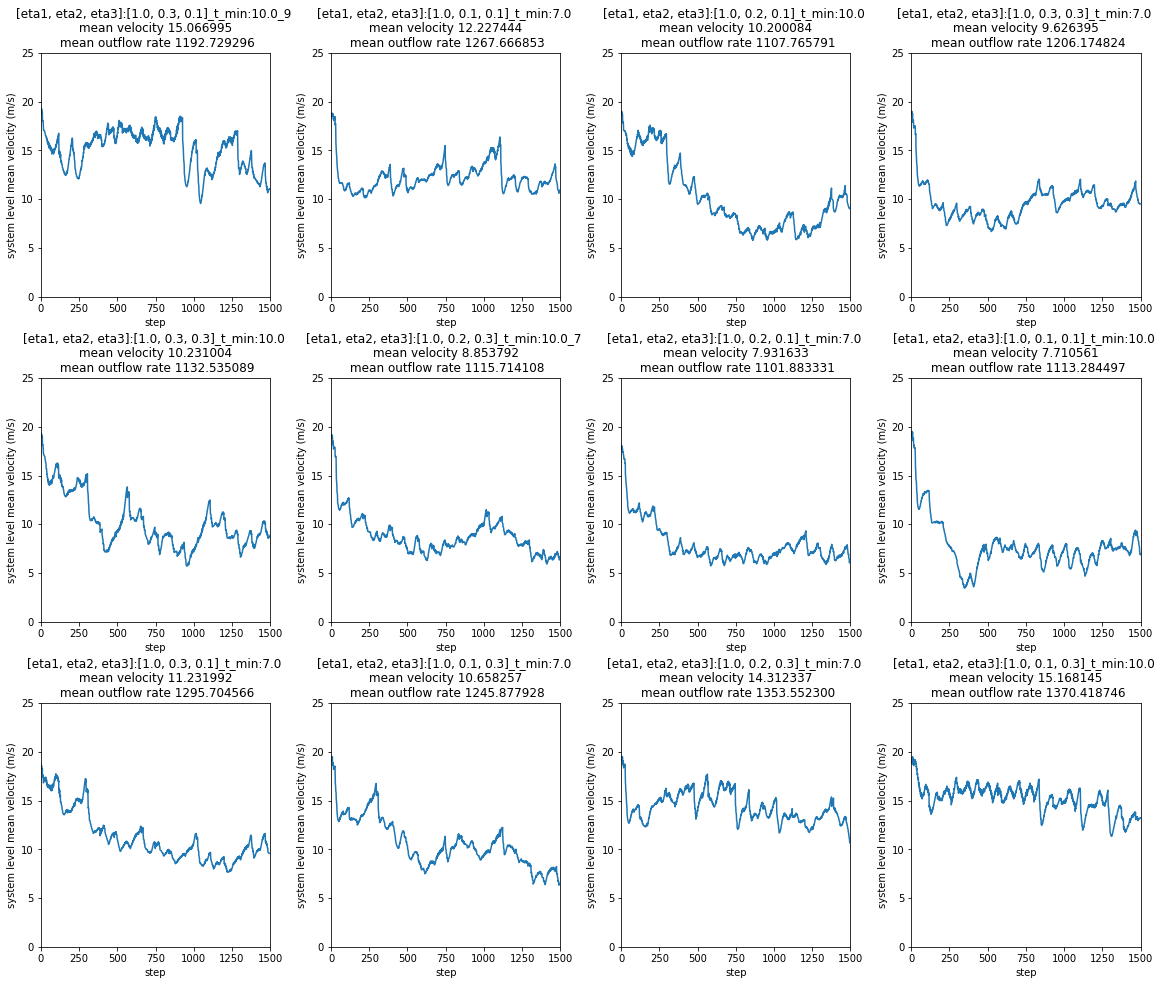

In [3]:
num_exp = len(results)
ncols = math.ceil(math.sqrt(num_exp))
nrows = math.ceil(num_exp / ncols)
vel_fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
vel_fig.tight_layout(h_pad=8.0, w_pad=3.0)

for i, item in enumerate(results.items()):
    key, value = item
    vel = results[key]['mean_vel']
    outflow = results[key]['outflow']
    col = math.floor(i/ncols)
    row = i%ncols
    axes[col, row].plot(vel)
    axes[col, row].set_ylabel('system level mean velocity (m/s)')
    axes[col, row].set_xlabel('step')
    title = key + ' \n mean velocity {:3f}'.format(np.mean(vel))
    title = title + ' \n mean outflow rate {:3f}'.format(np.mean(outflow))
    axes[col, row].set_title(title)
    axes[col, row].set_xlim([0, len(vel)])
    axes[col, row].set_ylim([0, 25])
plt.subplots_adjust(top=0.8)

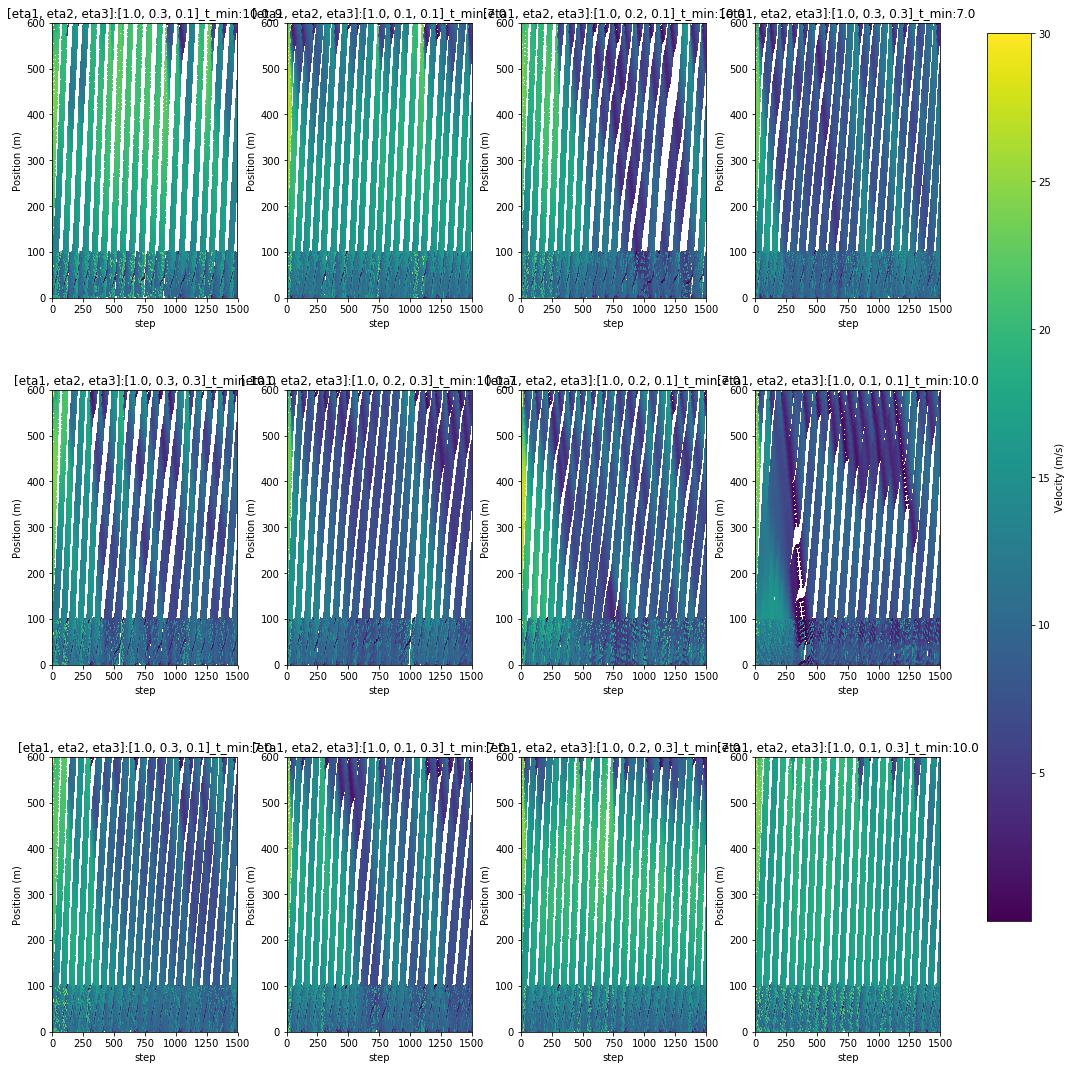

In [6]:
num_exp = len(results)
ncols = math.ceil(math.sqrt(num_exp))
nrows = math.ceil(num_exp / ncols)
space_fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
space_fig.tight_layout(h_pad=8.0, w_pad=3.0)

for i, item in enumerate(results.items()):
    key, value = item
    vel_map = results[key]['vel_map']
    x = np.arange(int(env.env_params.horizon))
    y = np.arange(0, int(left_length), step=0.1)
    xx, yy = np.meshgrid(x, y)
    col = math.floor(i/ncols)
    row = i%ncols
    im = axes[col, row].pcolormesh(xx, yy, vel_map.T)
    axes[col, row].set_ylabel('Position (m)')
    axes[col, row].set_xlabel('step')
    title = key
    axes[col, row].set_title(title)

clb = space_fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)

clb.set_clim(0, 30)
clb.set_label('Velocity (m/s)')
title = AGENT + ' Space-Time Diagram of 600 meter merge road'
plt.subplots_adjust(top=0.9, right=0.8)

In [7]:
# save figures
filename = 'compare_results' + '.png'
vel_dir = '../result/MultiMerge/' + AGENT + '/' + exp_name + '/mean_velocity/'
space_dir = '../result/MultiMerge/' + AGENT + '/' + exp_name + '/space_time_diagram/'
os.makedirs(vel_dir, exist_ok=True)
os.makedirs(space_dir, exist_ok=True)

vel_fig.savefig(vel_dir + filename)
space_fig.savefig(space_dir + filename)